<a href="https://colab.research.google.com/github/FarrazNouval/fcc-machine-learning-projects/blob/main/predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2022-11-29 09:15:20--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.006s  

2022-11-29 09:15:20 (8.32 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


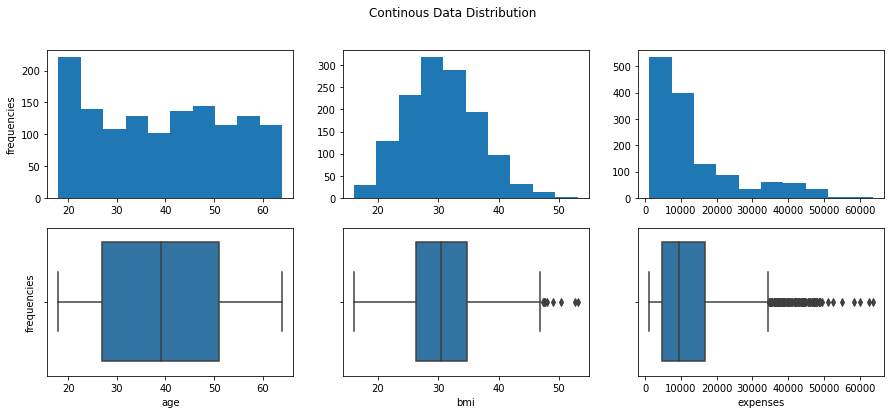

In [32]:
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
fig.suptitle('Continous Data Distribution')

axes[0, 0].hist(x=dataset.age)
axes[0, 0].set_ylabel('frequencies')

sns.boxplot(x=dataset.age, ax=axes[1, 0])
axes[1, 0].set_xlabel('age')
axes[1, 0].set_ylabel('frequencies')

axes[0, 1].hist(x=dataset.bmi)

sns.boxplot(x=dataset.bmi, ax=axes[1, 1])
axes[1, 1].set_xlabel('bmi')

axes[0, 2].hist(x=dataset.expenses)

sns.boxplot(x=dataset.expenses)
axes[1, 2].set_xlabel('expenses');


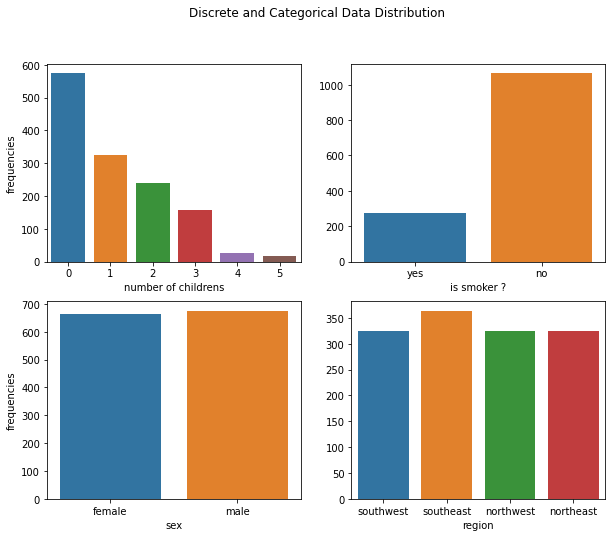

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Discrete and Categorical Data Distribution')

sns.countplot(x=dataset.children, ax=axes[0, 0])
axes[0, 0].set_xlabel('number of childrens')
axes[0, 0].set_ylabel('frequencies')

sns.countplot(x=dataset.smoker, ax=axes[0, 1])
axes[0, 1].set_xlabel('is smoker ?')
axes[0, 1].set_ylabel('')

sns.countplot(x=dataset.sex, ax=axes[1, 0])
axes[1, 0].set_xlabel('sex')
axes[1, 0].set_ylabel('frequencies')


sns.countplot(x=dataset.region, ax=axes[1, 1])
axes[1, 1].set_xlabel('region')
axes[1, 1].set_ylabel('');


In [15]:
cols = dataset.columns
input_cols = list(cols)[:-1]
target = list(cols)[-1]

inputs_df = dataset[input_cols].copy()
target = dataset[target]

print(type(inputs_df))
inputs_df

<class 'pandas.core.frame.DataFrame'>


,age,sex,bmi,children,smoker,region
0,19,female,27.9,0,yes,southwest
1,18,male,33.8,1,no,southeast
2,28,male,33.0,3,no,southeast
3,33,male,22.7,0,no,northwest
4,32,male,28.9,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest
1334,18,female,31.9,0,no,northeast
1335,18,female,36.9,0,no,southeast
1336,21,female,25.8,0,no,southwest


In [16]:
print(type(target))
target

<class 'pandas.core.series.Series'>


0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: expenses, Length: 1338, dtype: float64

In [17]:
numeric_cols = list(inputs_df.dtypes[inputs_df.dtypes != 'object'].index)
categorical_cols = list(inputs_df.dtypes[inputs_df.dtypes == 'object'].index)

num_data = inputs_df[numeric_cols]
cat_data = inputs_df[categorical_cols]


In [18]:
num_data


,age,bmi,children
0,19,27.9,0
1,18,33.8,1
2,28,33.0,3
3,33,22.7,0
4,32,28.9,0
...,...,...,...
1333,50,31.0,3
1334,18,31.9,0
1335,18,36.9,0
1336,21,25.8,0


In [19]:
cat_data

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


In [20]:
import sklearn 
from sklearn.preprocessing import OneHotEncoder

In [21]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(cat_data)
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(cat_data)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
inputs_df

,age,sex,bmi,children,smoker,region,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.9,0,yes,southwest,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,male,33.8,1,no,southeast,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,male,33.0,3,no,southeast,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,male,22.7,0,no,northwest,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,male,28.9,0,no,northwest,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18,female,31.9,0,no,northeast,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18,female,36.9,0,no,southeast,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21,female,25.8,0,no,southwest,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [23]:
from sklearn.model_selection import train_test_split

train_features, test_dataset, train_labels, test_labels = train_test_split(inputs_df[numeric_cols + encoded_cols],
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=42)


In [24]:
train_features


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
560,46,20.0,2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1285,47,24.3,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1142,52,24.9,0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
969,39,34.3,5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
486,54,21.5,3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1095,18,31.4,4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1130,39,23.9,5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1294,58,25.2,0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
860,37,47.6,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [25]:
train_labels

560      9193.84
1285     8534.67
1142    27117.99
969      8596.83
486     12475.35
          ...   
1095     4561.19
1130     8582.30
1294    11931.13
860     46113.51
1126    10214.64
Name: expenses, Length: 1070, dtype: float64

In [26]:
model = keras.Sequential([layers.Input(shape=(len(train_features.keys()),)),
                          layers.Normalization(axis=-1),
                          layers.Dense(11, activation='relu'),
                          layers.Dropout(0.1),
                          layers.Dense(64, activation='relu'),
                          layers.Dropout(0.1),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(1, activation='relu')])




In [27]:
model.compile(loss='mean_absolute_error',
              optimizer=keras.optimizers.RMSprop(0.001),
              metrics=['mae', 'mse']) 

In [28]:
#setting callbacks
#reduce learning rate
set_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                           patience=7,
                                           min_lr=0.0001,
                                           verbose=1)

#set checkpoint
set_cp = keras.callbacks.ModelCheckpoint(monitor='loss',
                                         filepath='/content/model.h5',
                                         save_best_only=True,
                                         verbose=1)
#custom callback for early stopping
class SpecificStopper(keras.callbacks.Callback):
  def __init__(self, exp_loss, exp_val_loss):
    super(SpecificStopper).__init__()
    self.exp_loss = exp_loss
    self.exp_val_loss = exp_val_loss
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    if ((loss <= self.exp_loss) and (val_loss <= self.exp_val_loss)):
      print('early stopping')
      self.model.stop_training = True

set_stop = SpecificStopper(3500, 3500)

In [29]:
history = model.fit(train_features,
                    train_labels,
                    validation_split=0.2,
                    verbose=1,
                    epochs=1000,
                    callbacks=[set_lr, set_cp, set_stop])

Epoch 1/1000
27/27 [==============================] - ETA: 0s - loss: 13486.8799 - mae: 13486.8799 - mse: 324563392.0000 
Epoch 1: loss improved from inf to 13486.87988, saving model to /content/model.h5
27/27 [==============================] - 1s 12ms/step - loss: 13486.8799 - mae: 13486.8799 - mse: 324563392.0000 - val_loss: 12585.2568 - val_mae: 12585.2568 - val_mse: 308431744.0000 - lr: 0.0010
Epoch 2/1000
 1/27 [>.............................] - ETA: 0s - loss: 11725.8301 - mae: 11725.8301 - mse: 246893024.0000
Epoch 2: loss improved from 13486.87988 to 13374.95898, saving model to /content/model.h5
27/27 [==============================] - 0s 4ms/step - loss: 13374.9590 - mae: 13374.9590 - mse: 321324512.0000 - val_loss: 12419.0713 - val_mae: 12419.0713 - val_mse: 303914624.0000 - lr: 0.0010
Epoch 3/1000
22/27 [=======================>......] - ETA: 0s - loss: 12997.2041 - mae: 12997.2041 - mse: 304720352.0000
Epoch 3: loss improved from 13374.95898 to 13143.84277, saving model to

In [30]:
model = keras.models.load_model('/content/model.h5')


9/9 - 0s - loss: 3253.8745 - mae: 3253.8745 - mse: 35359052.0000 - 145ms/epoch - 16ms/step
Testing set Mean Abs Error: 3253.87 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 2ms/step


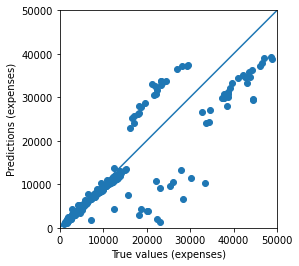

In [31]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
